In [59]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import json
import collections
from sklearn.model_selection import train_test_split
import sklearn.cross_validation as cv
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from scipy import interp
from IPython.display import Markdown
import warnings; 
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pixiedust
# %%pixie_debugger

%matplotlib inline

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table USER_PREFERENCES created successfully
Table service_connections created successfully


In [2]:
import sys
import re
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
data_path = '/home/ds/dev/data/plrm/plrm.xlsx'

In [3]:
df_data_raw = pd.read_excel(data_path,sheetname='Data')

#### utils

In [4]:
def prnrows(df, desc=''):    
    print('%s num rows: ' % desc, len(df))

In [5]:
def plot_bar(v,nlargest=50):
    plt.figure(figsize=(10,3))
    v[v != ''].value_counts().nlargest(nlargest).plot(kind='bar',title=v.name)

In [6]:
def chunks(l, n):    
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [7]:
# def draw_hists(df, variables, n_rows, n_cols):
#     fig=plt.figure()
#     for i, var_name in enumerate(variables):
#         ax=fig.add_subplot(n_rows,n_cols,i+1)
#         df[var_name].hist(bins=10,ax=ax)
#         ax.set_title(var_name+" distribution")
#     fig.tight_layout()  
#     plt.show()

In [8]:
def plot_corr(df_corr,size=(16, 17)):
    f, ax = plt.subplots(figsize=size)

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    ax = sns.heatmap(df_corr,  cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, robust=True,
                square=False, linewidths=.5, cbar_kws={"shrink": .5})
    ax.xaxis.set_ticks_position('top')
    plt.xticks(rotation=45)

    plt.show()

In [9]:
def plot_auc(y_true, y_score):
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(7,7))

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
def run_crossval(X,y, fitter, n_folds=5):

    skf_cv = cv.StratifiedKFold(y, n_folds=n_folds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    plt.figure(figsize=(7,7))

    for i, (train, test) in enumerate(skf_cv):
        model = fitter.fit(X.iloc[train], y.iloc[train])
        probas_ = model.predict_proba(X.iloc[test])
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
#         probas_ = model.decision_function(X.iloc[test])
#         fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(skf_cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print(mean_auc)
    
    return pd.DataFrame(data=np.array([tpr, fpr,thresholds]).T, columns=['tpr','fpr','threshold'])

#### data prep

In [11]:
df_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289023 entries, 0 to 289022
Data columns (total 20 columns):
Game                   289023 non-null object
Affiliate              289023 non-null object
Platform               289023 non-null object
Country                289023 non-null object
Placement              289023 non-null object
Impressions            289023 non-null int64
Clicks                 289023 non-null int64
Installs               289023 non-null int64
FiveBattles            289023 non-null int64
FiveLevels             289023 non-null int64
ClanJoins              289023 non-null int64
FiveMinutes            289023 non-null int64
TenMinutes             289023 non-null int64
DayOneRetentions       289023 non-null int64
DaySevenRetentions     289023 non-null int64
DayThirtyRetentions    289023 non-null int64
Spend                  289023 non-null float64
Depositors             289023 non-null int64
Deposits               289023 non-null int64
DepositAmount          2890

In [12]:
prnrows(df_data_raw, "all data")
df_data_raw.dtypes

all data num rows:  289023


Game                    object
Affiliate               object
Platform                object
Country                 object
Placement               object
Impressions              int64
Clicks                   int64
Installs                 int64
FiveBattles              int64
FiveLevels               int64
ClanJoins                int64
FiveMinutes              int64
TenMinutes               int64
DayOneRetentions         int64
DaySevenRetentions       int64
DayThirtyRetentions      int64
Spend                  float64
Depositors               int64
Deposits                 int64
DepositAmount          float64
dtype: object

In [13]:
df_data_raw.describe(exclude=[np.object])

,Impressions,Clicks,Installs,FiveBattles,FiveLevels,ClanJoins,FiveMinutes,TenMinutes,DayOneRetentions,DaySevenRetentions,DayThirtyRetentions,Spend,Depositors,Deposits,DepositAmount
count,2.890230e+05,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000,289023.000000
mean,4.435675e+04,70.376707,3.581438,0.029001,0.109427,0.139608,1.118648,0.723247,0.277881,0.063805,0.001460,18.866674,0.072191,0.196292,1.734511
std,2.876328e+05,571.547354,43.364587,0.463842,1.355682,1.213403,12.511966,7.086105,2.719952,0.625191,0.071399,124.035543,2.068892,6.333343,61.894657
min,1.850000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
25%,3.904000e+03,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.440000,0.000000,0.000000,0.000000
50%,8.605000e+03,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.180000,0.000000,0.000000,0.000000
75%,2.375800e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.440000,0.000000,0.000000,0.000000
max,3.335934e+07,125671.000000,4762.000000,50.000000,132.000000,82.000000,1482.000000,731.000000,230.000000,43.000000,11.000000,13138.680000,607.000000,1971.000000,14355.630000


In [14]:
# filter out wrong records
df_data_all = df_data_raw.query('not (Installs == 0 & Depositors > 0)')
prnrows(df_data_all, "data after wrong recs removal")

data after wrong recs removal num rows:  287815


#### params

In [15]:
isgood_segment_thresh = 0.02
dep_vars = ['Depositors','Deposits','DepositAmount','dep_rate','isgood']

#### add features


In [16]:
# calc depositors rate and is good segment
df_data_all['dep_rate'] = df_data_all['Depositors']/df_data_all['Installs']

df_data_all['isgood'] = df_data_all['dep_rate'] > isgood_segment_thresh

In [17]:
# calc additional features
df_data_all['impr_cost'] = df_data_all['Impressions']/df_data_all['Spend']
df_data_all['install_cost'] = df_data_all['Clicks']/df_data_all['Spend']
df_data_all['click_cost'] = df_data_all['Installs']/df_data_all['Spend']
df_data_all['install_ratio'] = df_data_all['Installs']/df_data_all['Impressions']

add_vars = ['impr_cost','install_cost','click_cost','install_ratio']

In [18]:
df_data_all.fillna(0,inplace=True)

#### split data

In [19]:
df_train, df_test = train_test_split(df_data_all, stratify=df_data_all['isgood'], test_size=0.3)
prnrows(df_train,"train"),prnrows(df_test, "test")

train num rows:  201470
test num rows:  86345


(None, None)

False    0.988892
True     0.011108
Name: isgood, dtype: float64

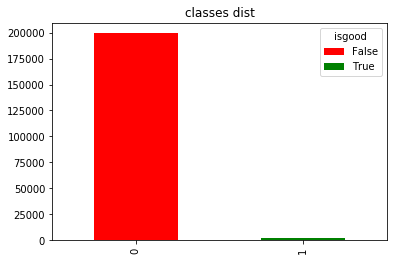

In [20]:
c=df_train.groupby(by=['isgood']).count() \
  .reset_index().pivot(columns='isgood',values='dep_rate') \
  .plot.bar(use_index=True,stacked=True,colors=['red','green'],title='classes dist');
df_train['isgood'].value_counts(normalize=True)

>dataset is higly imbalanced => we"ll have to handle that later oversampling/adjust minority class weights during learning

#### data explr

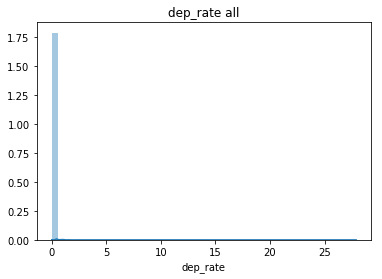

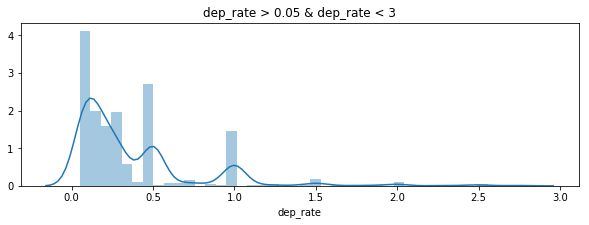

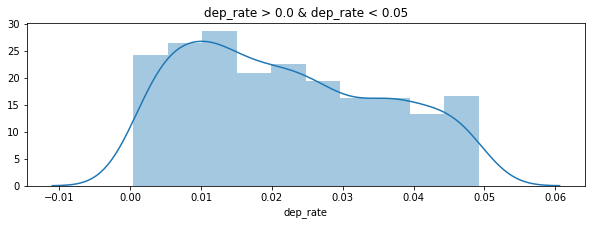

In [21]:
# plt.ioff() 
plt.title('dep_rate all');
sns.distplot(df_train['dep_rate']);
plt.figure(figsize=(10,3))
plt.title('dep_rate > 0.05 & dep_rate < 3');
sns.distplot(df_train.query('dep_rate > 0.05 & dep_rate < 3')['dep_rate']);
plt.figure(figsize=(10,3))
plt.title('dep_rate > 0.0 & dep_rate < 0.05');
sns.distplot(df_train.query('dep_rate > 0.0 & dep_rate < 0.05')['dep_rate']);


In [69]:
for c in df_train.select_dtypes(include=['object']).columns:        
    print('=================',c,'===================','num unique: ',len(df_train[c].unique()))
    print(df_train[c].value_counts().nlargest(20))

================= Game =================== num unique:  5
Vikings            139723
Throne              47912
Terminator           9346
Soldiers Mobile      3092
Soldiers Inc         1397
Name: Game, dtype: int64
================= Affiliate =================== num unique:  7
Affiliate 3    129070
Affiliate 2     46679
Affiliate 1     18833
Affiliate 4      6424
Affiliate 7       440
Affiliate 5        23
Affiliate 6         1
Name: Affiliate, dtype: int64
================= Platform =================== num unique:  3
Web        113981
Android     44471
iOS         43018
Name: Platform, dtype: int64
================= Country =================== num unique:  8
WW           131462
US            26335
France        15557
Germany       11680
UK             8465
Russia         6802
Australia       862
Turkey          307
Name: Country, dtype: int64
================= Placement =================== num unique:  101507
Placement 13554     19
Placement 10425     18
Placement 15083     18
Placement

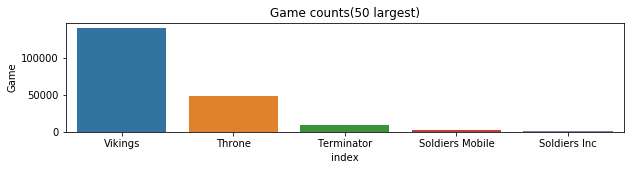

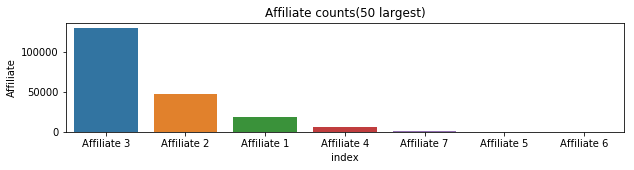

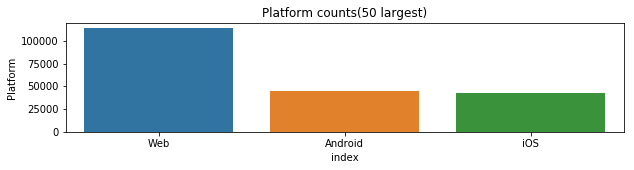

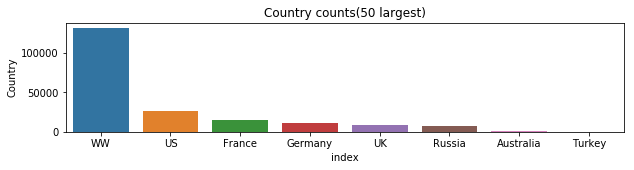

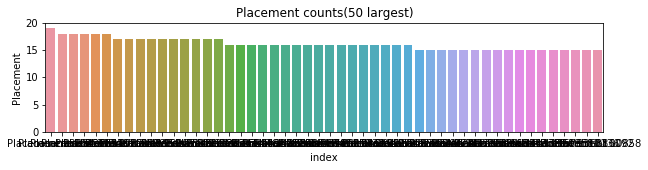

In [64]:
for c in df_train.select_dtypes(include=['object']).columns:        
    z=plt.figure(figsize=(10,2))
    z=plt.title('%s counts(50 largest)' % c);    
    z=sns.barplot(data=pd.DataFrame(df_train[c].value_counts().nlargest(50)).reset_index(), x='index',y=c);

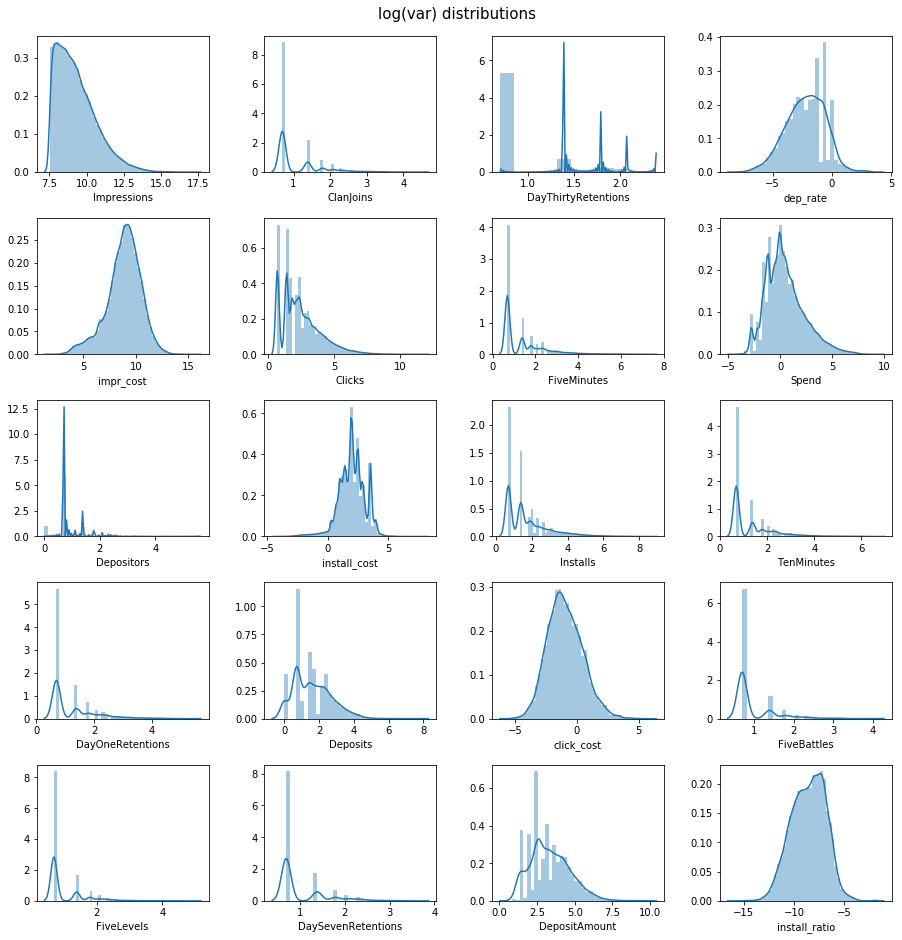

In [23]:
cols = df_train.select_dtypes(include=[np.number]).columns
ncols=4
nrows = len(cols)//ncols
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(13,13));
plt.tight_layout(pad=2.5) 
z=fig.suptitle("log(var) distributions", fontsize=15,y=1)
for i,c in enumerate(cols):    
    logd = df_train.query('%s > 0.0' % c)[c].apply(np.log);
    ax = axs[i%nrows,i%ncols]   
#     z=ax.set_title('log(%s) distribution' % c);
    z=sns.distplot(logd,ax=ax)
fig.show()

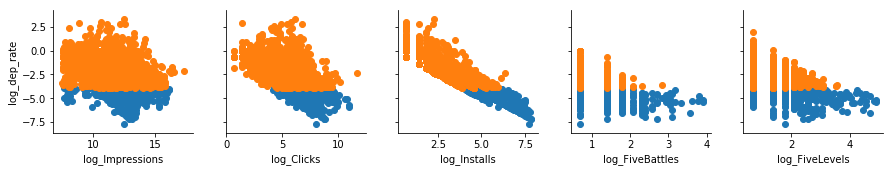

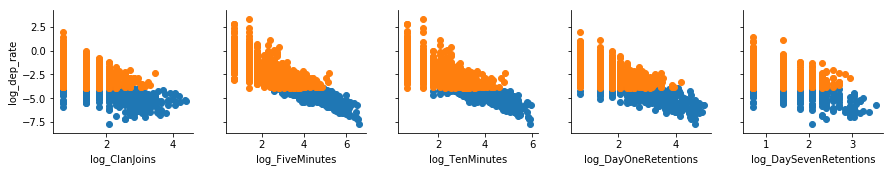

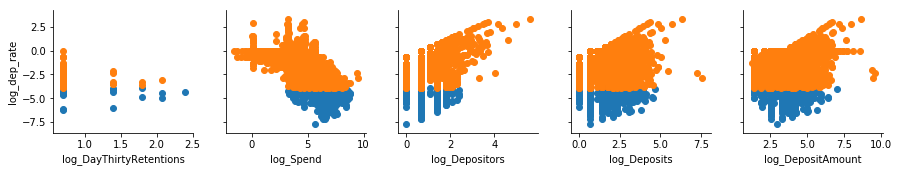

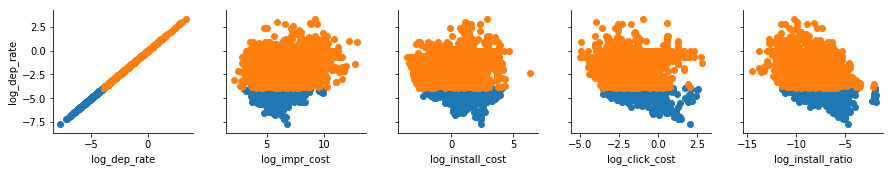

In [26]:
for cols in chunks(df_train.select_dtypes(include=[np.number]).columns, 5):
    logd = df_train.query('%s > 0.0' % c);
    cols_log = list(map(lambda c: 'log_%s' % c, cols))
    logd[cols_log] = logd[cols].apply(np.log)    
    logd['log_dep_rate'] = logd['dep_rate'].apply(np.log)    
    g = sns.PairGrid(logd,
                     x_vars=cols_log,
                      y_vars=['log_dep_rate']
                     ,hue='isgood')
    g = g.map(plt.scatter)

In [24]:
# for c in df_train.select_dtypes(include=['object']).columns:      
#     count_by_c=df_train.groupby(by=['isgood',c]).count() \
#       .reset_index().pivot(index=c,columns='isgood',values='dep_rate')
#     z=count_by_c.plot.bar(use_index=True,stacked=True,colors=['red','green'],title='classes dist by %s' % c);


In [32]:
corr = df_train.corr(method='pearson')

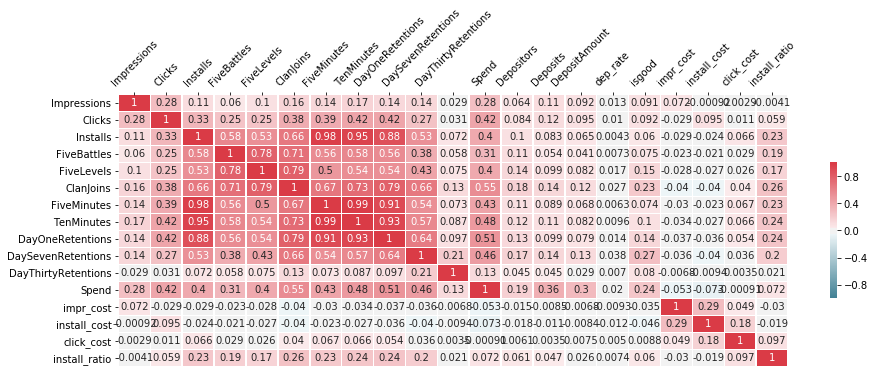

In [33]:
plot_corr(corr.drop(dep_vars,axis=0),size=(15,5))

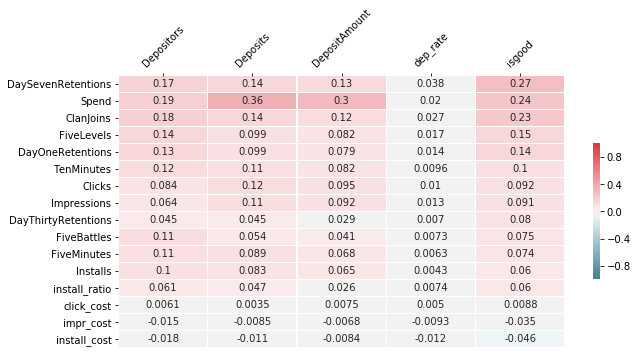

In [36]:
plot_corr(corr.drop(set(corr.columns.values) - set(dep_vars),axis=1) \
              .drop(dep_vars,axis=0)    \
              .sort_values(by=['isgood'],ascending=False)
                    ,size=(10,5))

#### build model

In [37]:
from sklearn.datasets import make_classification
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.feature_extraction.text import HashingVectorizer,TfidfVectorizer
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.model_selection import train_test_split

In [38]:
df_X = df_train.drop(dep_vars,axis=1).drop(['Placement','Spend'],axis=1)
df_Y = df_train['isgood']

In [40]:
Markdown("<font color='red'><b>Ensure we don't use dependent columns as part of the model.</b></font>")
df_X.columns
df_Y.value_counts()

<font color='red'><b>Ensure we don't use dependent columns as part of the model.</b></font>

Index(['Game', 'Affiliate', 'Platform', 'Country', 'Impressions', 'Clicks',
       'Installs', 'FiveBattles', 'FiveLevels', 'ClanJoins', 'FiveMinutes',
       'TenMinutes', 'DayOneRetentions', 'DaySevenRetentions',
       'DayThirtyRetentions', 'impr_cost', 'install_cost', 'click_cost',
       'install_ratio'],
      dtype='object')

False    199232
True       2238
Name: isgood, dtype: int64

In [47]:
numerical_cols =df_X.dtypes[df_train.dtypes!= 'object'].index
categorical_cols = df_X.dtypes[df_train.dtypes== 'object'].index
numerical_cols
categorical_cols

Index(['Impressions', 'Clicks', 'Installs', 'FiveBattles', 'FiveLevels',
       'ClanJoins', 'FiveMinutes', 'TenMinutes', 'DayOneRetentions',
       'DaySevenRetentions', 'DayThirtyRetentions', 'impr_cost',
       'install_cost', 'click_cost', 'install_ratio'],
      dtype='object')

Index(['Game', 'Affiliate', 'Platform', 'Country'], dtype='object')

In [48]:
mapper = DataFrameMapper(
    [(col, preprocessing.LabelBinarizer()) for col in categorical_cols] + \
#     [(numerical_cols, preprocessing.FunctionTransformer(np.log1p))]
    [(numerical_cols, None)]
                        )

prepare_pipeline = make_pipeline(mapper,
                                 preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
#                         PolynomialFeatures(degree=1, interaction_only=True),                         
#                         preprocessing.StandardScaler()
                        ) 


forest = ensemble.ExtraTreesClassifier(n_estimators=250, random_state=0,class_weight='balanced_subsample')
fit_pipeline_f1 = make_pipeline(prepare_pipeline, forest)  

In [49]:
fit_pipeline_f1.fit(df_X,df_Y.astype(int))

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('dataframemapper', DataFrameMapper(default=False, df_out=False,
        features=[('Game', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('Affiliate', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('Platform',...estimators=250, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

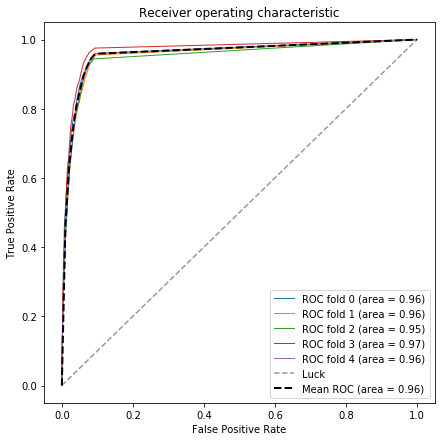

0.9582062211354724


In [44]:
df_thresh = run_crossval(df_X, df_Y.astype(int), fit_pipeline_f1, n_folds=5)

In [ ]:
forest.

In [58]:
from sklearn import tree
# import pydot


import pydotplus
from IPython.display import Image

# (graph,) = pydot.graph_from_dot_file('tree_from_forest.dot')
# graph.write_png('tree_from_forest.png')


with open('dotfile.txt', 'w') as out:
#     content = tree.export_graphviz(estimator,out_file=None,feature_names =X_train.columns ,class_names=['Male','Female'], 
#                      filled=True, rounded=True, special_characters=True)
    content = tree.export_graphviz(forest.estimators_[0], out_file='tree_from_forest.dot')#,feature_names =df_X.columns )

    graph=pydotplus.graph_from_dot_data(content)

Image(graph.create_png())

TypeError: object of type 'NoneType' has no len()

#### plot feature importance

<b>I use another categorical features encoder here because of scikit limitation api limitation   which cannot treat requires encoding categorical features for all kinds of models.   Since in test set we can have categorical values that are not present in the training set I use BinaryEncoder in the model.   but LabelEncoder here since it's easear to decode values using it</b>

Pipeline(steps=[('pipeline', Pipeline(steps=[('dataframemapper', DataFrameMapper(default=False, df_out=False,
        features=[('Game', LabelEncoder()), ('Affiliate', LabelEncoder()), ('Platform', LabelEncoder()), ('Country', LabelEncoder()), (Index(['Impressions', 'Clicks', 'Installs', 'FiveBattles', 'Five...estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

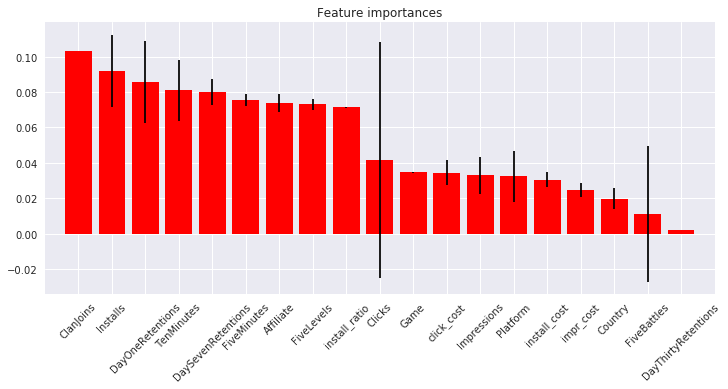

Feature ranking:
1. ClanJoins (0.103199)
2. Installs (0.092024)
3. DayOneRetentions (0.085745)
4. TenMinutes (0.080993)
5. DaySevenRetentions (0.080062)
6. FiveMinutes (0.075587)
7. Affiliate (0.073966)
8. FiveLevels (0.073007)
9. install_ratio (0.071412)
10. Clicks (0.041455)
11. Game (0.034634)
12. click_cost (0.034361)
13. Impressions (0.032992)
14. Platform (0.032290)
15. install_cost (0.030562)
16. impr_cost (0.024723)
17. Country (0.019798)
18. FiveBattles (0.011167)
19. DayThirtyRetentions (0.002023)


In [35]:
Markdown("<b>I use another categorical features encoder here because of scikit limitation api limitation \
  which cannot treat requires encoding categorical features for all kinds of models. \
  Since in test set we can have categorical values that are not present in the training set I use BinaryEncoder in the model. \
  but LabelEncoder here since it's easear to decode values using it</b>")

mapper2 = DataFrameMapper(
    [(col, preprocessing.LabelEncoder()) for col in categorical_cols] + \
    [(numerical_cols, None)])

prepare_pipeline2 = make_pipeline(mapper2,preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)) 
forest2 = ensemble.ExtraTreesClassifier(n_estimators=250, random_state=0,class_weight='balanced_subsample')

fit_pipeline_f2 = make_pipeline(prepare_pipeline2, forest2)  
fit_pipeline_f2.fit(df_X,df_Y.astype(int))

importances = forest2.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]



# Plot the feature importances of the forest
plt.ioff()
z=plt.figure(figsize=(12,5));
z=plt.title("Feature importances");
z=plt.bar(range(df_X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center");


z=plt.xticks(range(df_X.shape[1]), df_X.columns[indices].values.tolist(),rotation=45);
z=plt.xlim([-1, df_X.shape[1]]);
plt.show();

print("Feature ranking:")
for f in range(df_X.shape[1]):
    print("%d. %s (%f)" % (f + 1, df_X.columns.values[indices[f]], importances[indices[f]]))

#### choose threshold - explained in summary

In [36]:
df_thresh.head(n=20)

,tpr,fpr,threshold
0,0.000000,0.000000,1.944
1,0.000000,0.000025,0.944
2,0.000000,0.000050,0.924
3,0.002237,0.000050,0.904
4,0.002237,0.000100,0.864
5,0.006711,0.000100,0.848
6,0.011186,0.000100,0.832
7,0.011186,0.000151,0.820
8,0.017897,0.000151,0.800
9,0.020134,0.000176,0.792


#### Test

In [37]:
df_X_test = df_test.drop(dep_vars,axis=1).drop(['Placement','Spend'],axis=1)
df_Y_test = df_test['isgood']

In [38]:
y_proba =fit_pipeline_f1.predict_proba(df_X_test)[:,1]
y_true = df_Y_test.astype(int).values

In [39]:
len(list(filter(lambda v: v>0.5, y_proba)))
len(list(filter(lambda v: v==True,y_true)))

308

959

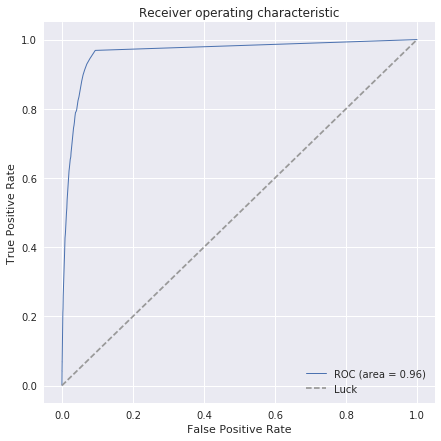

In [40]:
plot_auc(y_true, y_proba)

### Summary
<b>Model</b>
<br/>
> I have chosed to use decision trees ensemble classifier (ExtraTreesClassifier)
<br/>
> Cons: 
- Provides output in terms of probability
- Out-of-the-box support of imbalanced data
- implicitly performs feature selection
- Handles non-linearities in the data
- Easy to use - needs less preprocessing like data transformations, encoding, scaling 
- Provides relative importance of features


> Pros:
- Trees ensemble contains a lot of trees, so it harder to interpret for human
- Does not contain coefficients for independent variables - hard to tune dependent class by changing specific variable (for example logistic regression allows that).

<b>Results and conclusions</b><br/>
> 
- Test set size was 30% of all data randomly sampled
- Dataset was imbalanced, only 1.1% of samples were with good deposit rate (positive). The imbalance was treated by using increased weights for positive samples (using parameter class_weight='balanced_subsample') during training of the model.  
- During data exploration I performed log transformation to numerical variables to make graphs more readable. While opposed to other kinds of models (e.g. regression) decision tree doesn't implies normality of data, I included log transform as part of data processing pipline for consistency with data exploration. 
- Model accuracy was measured using ROC are wich shows TPR(recall) vs FPR(1-Specificity) tradeoff according to threshold. ROC curve espcially usefull in case of imballanced dataset.
ROC area for test set is 96%
- Threshold table with corresponding TPR/FPR provided in the body of the notebook. I wouldn't offer here using particular threshold as it should be chosen accroding to business needs from the table. For example if my purpose was to minimize campaign spendings I would choose threshold which minimizes FPR (minimize bad campaigns classified as good), of course that would come at cost of some good campaigns would be stoped despite they are actually good, resulted in missed revenue from deposits.
- Interesting fact that I notice is that one of most strong predictor variables is ClanJoins (both according to features importance rank from the model and pearson correlation diagram). Which is makes sense for me as far as I can understand the domain - player which joins groups of other players exposed to "peer pressure" and competition, so he tries to gain advantage by bying improvements. Of coarse this fact can be used in the game process to encourage people to join groups.

<b>Outliers/Problems detected</b><br/>
> 
- I filtered out records with Installs == 0 and Depositors > 0 - it is illigal state, of coarse if there were no install there wouldn't be Depositors
- I hasitated regarding direct use of Spend variable, as I treated it like a campaign budget. It would be reasonable assumption that as much budget we would put into the campaign we would get better results. So I decided not to use it directly but to constract variables like click_cost, install_cost. 
<font color='red'><b>Using of Spend variable directly raised ROC area to 99%, but as I mentioned I decided not to use it.</b></font>
- I context of previous paragraph overall direct usage of count variables like installs, impressions etc. feels me like kind of problematic and should be assessed in terms of per cost/time. I allowe my self to use it directly here and added some ration variables in addition, but in real life I would consider use ratios instead.


<b>Summary graph</b><br/>
> In the body of the notebook

<b>Further improvements</b><br/>
> 
- continue with data exploration and feature ingineering.
- Use crossvalidation for model hyperparameters tuning (e.g. number of trees) using GridSearch.
- Try use other kinds of models (other kinds of tress ensembles, e.g. XGboost, classic Random Forest, AdaBoost, logistic regression etc. 
- If time-dependent data of compaign would be avalilable LSTM RNN (recurent neural net long-short term memory) can be used to model campaign evolving at time.
- In conext of already mentioned problem of count varianles direct usage and according to my understanding of the problem domain the purpose is to detect that campaign is good or bad as much early as possible, so as we should evaluate the campaign performance during campaign running. I would suggest using additonal features that would measure "success" and "conversion" rates - e.g. deposit per cost ratio, impressions/install ratio etc. I suppose these rates would change as campaign lifetime. Thus we would be able not only categorize campaign as good or bad but optimize as campaign evolves.
- I would also try to gather more data about placement parameters (size, time etc.) in order to optimize kinds of placements to purchase.